# Setup

## Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scikit-learn==0.22.2 numpy==1.18.2 torch==1.4.0 pandas jsonpickle nltk

## Imports

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import nltk
from nltk import pos_tag

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

from typing import Tuple, List, Dict, Optional, Any
from collections import Counter
import os
import json, jsonpickle
from tqdm.notebook import tqdm
from pprint import pprint

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
nltk.download("averaged_perceptron_tagger")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", DEVICE)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Using device:  cuda


## Loading data

In [5]:
hw_folder = "/content/drive/My Drive/Colab Notebooks/NLP/homework1"
data_folder = os.path.join(hw_folder, "data")
print(os.listdir(data_folder))

['test.tsv', 'dev.tsv', 'train.tsv']


In [0]:
train_dataset_path = os.path.join(data_folder, "train.tsv")
dev_dataset_path = os.path.join(data_folder, "dev.tsv")
test_dataset_path = os.path.join(data_folder, "test.tsv")

In [7]:
!head "/content/drive/My Drive/Colab Notebooks/NLP/homework1/data/train.tsv"

# Burgdorf had brought a capsule of cyanide for the occasion .
0	Burgdorf	PER
1	had	O
2	brought	O
3	a	O
4	capsule	O
5	of	O
6	cyanide	O
7	for	O
8	the	O


In [0]:
def read_dataset(path: str) -> Tuple[List[List[str]], List[List[str]]]:
    """
    Reads a dataset from a given path.

    Args:
        path: Path of the file stored in tsv format.

    Returns:
        A 2D list of tokens and another of associated labels.
    """
    tokens_s = []
    labels_s = []

    tokens = []
    labels = []

    with open(path) as f:
        for line in f:
            line = line.strip()
            if line.startswith('# '):
                tokens = []
                labels = []
            elif line == '':
                tokens_s.append(tokens)
                labels_s.append(labels)
            else:
                _, token, label = line.split('\t')
                tokens.append(token)
                labels.append(label)

    assert len(tokens_s) == len(labels_s)

    return tokens_s, labels_s

In [0]:
train_tokens, train_labels = read_dataset(train_dataset_path)
dev_tokens, dev_labels = read_dataset(dev_dataset_path)
test_tokens, test_labels = read_dataset(test_dataset_path)

#Data analysis

### Labels distribution

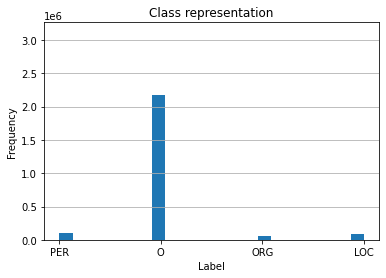

In [10]:
n, bins, patches = plt.hist(x=[label for sentence in train_labels for label in sentence], bins='auto')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Class representation')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq)*1.5)
plt.grid(axis="y")
plt.show()

We see a cospicuous class imbalance.

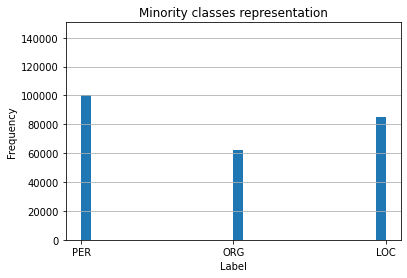

In [11]:
n, bins, patches = plt.hist(x=[label for sentence in train_labels for label in sentence if label != "O"], bins='auto')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Minority classes representation')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq)*1.5)
plt.grid(axis="y")
plt.show()

The minority classes are instead more or less comparable in representation.

### Sentence length distribution

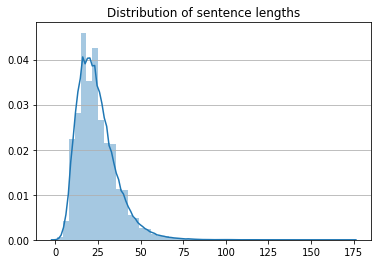

In [12]:
sentence_lengths = np.array([len(sentence) for sentence in train_tokens])
sns.distplot(sentence_lengths)
plt.title('Distribution of sentence lengths')
plt.grid(axis="y")
plt.show()

In [13]:
print("The mean of the distribution is", np.mean(sentence_lengths))
print("The std of the distribution is", np.std(sentence_lengths))
print("The minimum of the distribution is", np.min(sentence_lengths))
print("The maximum of the distribution is", np.max(sentence_lengths))

The mean of the distribution is 24.24757
The std of the distribution is 11.52035759406365
The minimum of the distribution is 1
The maximum of the distribution is 173


This is useful to choose a correct window size.

### Word length distribution

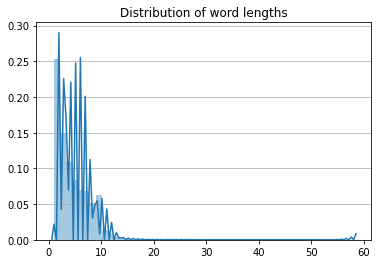

In [14]:
word_lengths = np.array([len(word) for sentence in train_tokens for word in sentence])
sns.distplot(word_lengths)
plt.title('Distribution of word lengths')
plt.grid(axis="y")
plt.show()

In [15]:
print("The mean of the distribution is", np.mean(word_lengths))
print("The std of the distribution is", np.std(word_lengths))
print("The minimum of the distribution is", np.min(word_lengths))
print("The maximum of the distribution is", np.max(word_lengths))

The mean of the distribution is 4.508116071012477
The std of the distribution is 2.8783422168376456
The minimum of the distribution is 1
The maximum of the distribution is 58


Due to the wide variation, I will use a custom character-level embedding that takes the first $k$ characters (prefix) and the last $k$ character (suffix) of a word. This will be fed to a BiLSTM to obtain the actual embedding I will train online along with the main model.

### POS tags relation with named entity types

In [0]:
def plot_pie_chart(labels, frequencies, cutoff=5, title="Pie chart"):
    cutoff = min(cutoff, len(labels))
    labels = labels[:cutoff] + ['Others']
    frequencies = frequencies[:cutoff] + [sum(frequencies[cutoff:])]
    explode = [0.05 for _ in range(len(labels))]
    fig, ax = plt.subplots(figsize=(8, 8))
    patches, texts, autotexts = ax.pie(frequencies, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
    [ t.set_fontsize(20) for t in texts ]
    [ a.set_fontsize(20) for a in autotexts ]
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title(title)
    plt.show()

In [17]:
labels = [label for sentence_labels in train_labels for label in sentence_labels]
pos_tags = []
for sentence in tqdm(train_tokens):
    for p in pos_tag(sentence):
        pos_tags.append(p[1])

POS_df = pd.DataFrame(data={"pos_tags": pos_tags, "labels": labels})
POS_df

,pos_tags,labels
0,NNP,PER
1,VBD,O
2,VBN,O
3,DT,O
4,NN,O
...,...,...
2424752,CC,O
2424753,VBN,O
2424754,TO,O
2424755,VB,O


In [0]:
POS_df_ner = POS_df.drop(POS_df[POS_df['labels'] == 'O'].index)

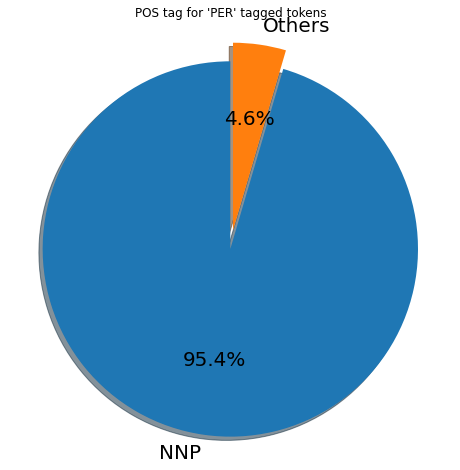

In [19]:
POS_df_per = POS_df_ner[POS_df_ner['labels'] == 'PER']
labels = POS_df_per['pos_tags'].value_counts().index
frequencies = POS_df_per['pos_tags'].value_counts().values

plot_pie_chart(labels.tolist(), frequencies.tolist(), cutoff=1, title="POS tag for \'PER\' tagged tokens")

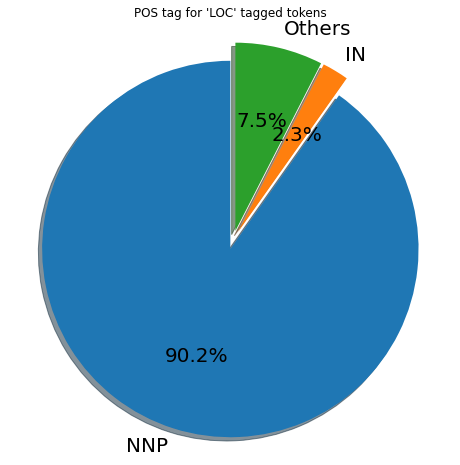

In [20]:
POS_df_loc = POS_df_ner[POS_df_ner['labels'] == 'LOC']
labels = POS_df_loc['pos_tags'].value_counts().index.tolist()
frequencies = POS_df_loc['pos_tags'].value_counts().values.tolist()

plot_pie_chart(labels, frequencies, cutoff=2, title="POS tag for \'LOC\' tagged tokens")

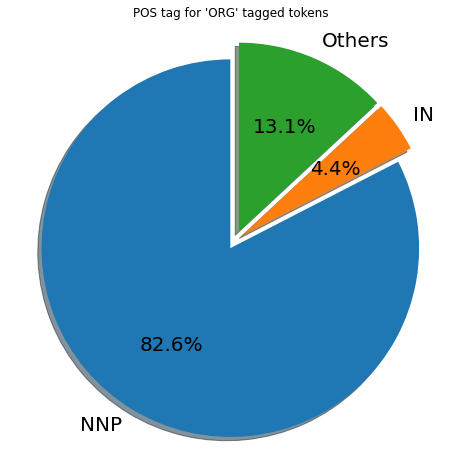

In [21]:
POS_df_org = POS_df_ner[POS_df_ner['labels'] == 'ORG']
labels = POS_df_org['pos_tags'].value_counts().index.tolist()
frequencies = POS_df_org['pos_tags'].value_counts().values.tolist()

plot_pie_chart(labels, frequencies, cutoff=2, title="POS tag for \'ORG\' tagged tokens")

As we see, there is a strong correlation between a token being a named entity and a token having the POS tag *NNP* (proper noun), as one might expect.

# Data preprocessing

### Utils functions to save parameters

In [0]:
def save_model_parameters(model, path, fname):
    fpath = os.path.join(path, fname)
    torch.save(model.state_dict(), fpath)

def load_model_parameters(model, fpath, device=DEVICE):
    model.load_state_dict(torch.load(fpath, map_location=torch.device(device)))

def json_dump(data, path, fname):
    fpath = os.path.join(path, fname)
    with open(fpath, 'w+') as f:
        frozen = jsonpickle.encode(data)
        json.dump(frozen, f, sort_keys=True)

def json_load(fpath):
    with open(fpath, 'r') as f:
        frozen = json.load(f)
        data = jsonpickle.decode(frozen)
    
    return data

### Vocabulary class(es)

In [0]:
class Vocabulary():
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
        """
        Custom base vocabulary class. 

        Args:
            counter:    Counter object with token occurrences.
            specials:   List of special tokens.
            min_freq:   Minimum number of occurrences for a token to be considered in
                        the vocabulary. (default: 1, all the tokens are considered)
        
        Attributes:
            stoi (dict):    Mapping from token strings (s) to indices (i)
            itos (dict):    Mapping from indices (i) to token strings (s)
        """

        self.stoi = dict()
        self.itos = dict()
        
        if counter is not None:
            idx = 0
            for s in specials:
                self.stoi[s] = idx
                self.itos[idx] = s
                idx += 1

            for tok, freq in counter.items():
                if freq >= min_freq:
                    self.stoi[tok] = idx
                    self.itos[idx] = tok
                    idx += 1
    
    def save(self, path: str, fname: str):
        """
        Saves the vocabulary (its two dictionaries) on disk.

        Args:
            path:   Path of the folder to save into.
            fname:  Name of the file to save onto.
        """
        state = {"stoi": self.stoi, "itos": self.itos}
        json_dump(state, path, fname)
    
    def load(self, fpath):
        """
        Loads the vocabulary (its two dictionaries) from disk.
        
        Args:
            fpath:  Path of the file to load from.
        """
        state = json_load(fpath)
        self.stoi = {s: int(i) for s, i in state["stoi"].items()}
        self.itos = {int(i): s for i, s in state["itos"].items()}

    def __getitem__(self, key):
        if type(key) == str:
            return self.stoi[key]
        elif type(key) == int:
            return self.itos[key]
        else:
            raise KeyError("{} is neither a token nor an index".format(key))
    
    def __len__(self):
        return len(self.itos)
    
    def __contains__(self, key):
        if type(key) == str:
            return key in self.stoi
        elif type(key) == int:
            return key in self.itos
        else:
            raise KeyError("{} is neither a token nor an index".format(key))

In [0]:
class TokenVocabulary(Vocabulary):
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
        """
        Custom vocabulary class for tokens. 
        """
        super().__init__(counter, specials, min_freq)

    def encode_tokens(self, sentence: List[dict]) -> List[int]:
        """
        Args:
            sentence: List of dictionaries with keys ("token", "label")
        Returns:
            The list of indices corresponding to the input tokens.
        """
        indices = list()
        for elem in sentence:
            if elem is None:
                indices.append(self["<pad>"])
            elif elem["token"] in self.stoi: # vocabulary string to integer
                indices.append(self[elem["token"]])
            else:
                indices.append(self["<unk>"])
        return indices

In [0]:
class LabelVocabulary(Vocabulary):
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
        """
        Custom vocabulary class for labels.
        """
        super().__init__(counter, specials, min_freq)
    
    def encode_labels(self, sentence: List[dict]) -> List[int]:
        indices = list()
        for elem in sentence:
            if elem is None:
                indices.append(self["<pad>"])
            elif elem["label"] in self.stoi: # vocabulary string to integer
                indices.append(self[elem["label"]])
            else:
                indices.append(self["<unk>"])
        
        return indices
    
    def decode_output(self, outputs:torch.Tensor) -> List[List[str]]:
        """
        Decodes the output of a model that has been trained on a dataset whose labels 
        have been indexed by this vocabulary.
        Args:
            outputs (Tensor):  Tensor with shape (batch_size, max_len, label_vocab_size)
                                containing the predictions of a model .
        Returns:
            The list of dimension (batch_size, max_len) with the decoded labels
        """
        batch_max_indices = torch.argmax(outputs, -1).tolist() # shape = (batch_size, max_len)
        predictions = list()
        for sample_max_indices in batch_max_indices:
            # vocabulary integer to string is used to obtain the corresponding word from the max index
            predictions.append([self.itos[i] for i in sample_max_indices])
        return predictions

In [0]:
class CharVocabulary(Vocabulary):
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
        """
        Custom vocabulary class for characters.
        """
        super().__init__(counter, specials, min_freq)
    
    def encode_chars(self, sentence: List[dict], k:int=5) -> List[List[int]]:
        """
        Computes a character-level encoding of the tokens in the sentence.
        To ensure homogeneity, I pick the first k chars and last k chars 
        of the token (to reflect prefix and suffix), padding in token is shorter
        Args:
            sentence:   List of dictionaries with keys ("token", "label")
            k:          Dimension of the prefix and suffix window of the word to consider.
        Returns:
            The list of list of indices corresponding to the characters of the input tokens.
        """
        sent_indices = list()
        for elem in sentence:
            if elem is None:
                # padding
                tok_indices = [self["<pad>"] for _ in range(2*k)]
            else:
                pre_indices = list()
                suf_indices = list()
                tok_indices = list()
                tok = elem["token"]
                for idx in range(k):
                    if idx >= len(tok):
                        # if token is shorter than k, fill with padding
                        pre_indices.append(self["<pad>"])
                        suf_indices.insert(0, self["<pad>"])
                    else:
                        pre_char = elem["token"][idx]
                        suf_char = elem["token"][-(idx+1)]
                        # prefix char
                        if pre_char in self.stoi: 
                            pre_indices.append(self[pre_char])
                        else:
                            pre_indices.append(self["<unk>"])
                        # suffix char
                        if suf_char in self.stoi: 
                            suf_indices.insert(0, self[suf_char])
                        else:
                            suf_indices.insert(0, self["<unk>"])
                
                # concatenate prefix indices and suffix indices in a 2k
                # character level representation of the token
                tok_indices.extend(pre_indices) 
                tok_indices.extend(suf_indices)
            
            sent_indices.append(tok_indices)
    
        return sent_indices

In [0]:
class POSVocabulary(Vocabulary):
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
        """
        Custom vocabulary class for tokens. 
        """
        super().__init__(counter, specials, min_freq)

    def encode_tags(self, sentence: List[dict]) -> List[int]:
        """
        Args:
            sentence: List of dictionaries with keys ("token", "label", "pos")
        Returns:
            The list of indices corresponding to the input POS tags.
        """
        indices = list()
        for elem in sentence:
            if elem is None:
                indices.append(self["<pad>"])
            elif elem["token"] in self.stoi: # vocabulary string to integer
                indices.append(self[elem["pos"]])
            else:
                indices.append(self["<unk>"])
        return indices

### Dataset class(es)

In [0]:
class CustomDataset(Dataset):
    def __init__(self, sentences: List[List[str]], labels: List[List[str]], 
                 window_size:int, window_shift:int=-1):
        """
        Custom dataset class for tokens and labels.
        
        Args:
            sentences:      The tokens organized in sentences.
            labels:         The labels of the tokens.
            window_size:    The maximum length of a sentence in terms of 
                            number of tokens.
            window_shift:   The number of tokens we shift the window 
                            over the sentence. 
                            Default value is -1 meaning that the window will
                            be shifted by window_size.
        
        Attributes:
            data:           (list(dict("inputs", "outputs", "chars"*))).
            encoded_data:   List of indices from data, given a vocabulary.
        """

        self.window_size = window_size
        self.window_shift = window_shift if window_shift > 0 else window_size
        self.data = self.create_windows(sentences, labels)
        self.encoded_data = None
    
    def index_dataset(self, 
                      vocabulary: TokenVocabulary, label_vocabulary: LabelVocabulary, 
                      char_vocabulary: Optional[CharVocabulary] = None, 
                      char_encoding_dim: int = 10):
        """
        Indexes the data using the correspondences given by vocabularies.

        Args:
            vocabulary:         Vocabulary for the tokens.
            label_vocabulary:   Vocabulary for the labels.
            char_vocabulary:    Character-level vocabulary.
            char_encoding_dim:  Dimension of the window to use to derive 
                                character-level representation of the tokens
        """
        
        self.encoded_data = list()
        for window in tqdm(self.data, desc="Indexing dataset"):
            encoded_tokens = torch.LongTensor(vocabulary.encode_tokens(window))
            encoded_labels = torch.LongTensor(label_vocabulary.encode_labels(window))
            encoded_elem = {"tokens":encoded_tokens, 
                            "labels":encoded_labels}
            if char_vocabulary is not None:
                encoded_chars = torch.LongTensor(char_vocabulary.encode_chars(window, k=char_encoding_dim//2))
                encoded_elem["chars"] = encoded_chars

            self.encoded_data.append(encoded_elem)

    def create_windows(self, sentences: List[List[str]], labels: List[List[str]]):
        """
        Creates fixed-length windows out of the sentences, to ensure length homogeneity
        across the samples of the dataset, breaking down longer sentences in more windows and
        filling up shorter sentences with padding if necessary.
       
        Args:
            sentences:  List of list of tokens organized in sentences.
            labels:     Labels of the tokens.
        """
        assert len(sentences) == len(labels)

        data = []
        for sentence, sent_labels in tqdm(zip(sentences, labels), desc="Creating windows", total=len(sentences)):
            for i in range(0, len(sentence), self.window_shift):
                tokens = sentence[i:i+self.window_size]
                labels = sent_labels[i:i+self.window_size]
                window = [{"token": t, "label": l} for t, l in zip(tokens, labels)]
                if len(window) < self.window_size:
                    window = window + [None]*(self.window_size - len(window))
                                
                data.append(window)
        
        return data
    
    def get_raw_element(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.encoded_data is None:
            raise RuntimeError("""Trying to retrieve elements but index_dataset
            has not been invoked yet! Be sure to invoce index_dataset on this object
            before trying to retrieve elements. In case you want to retrieve raw
            elements, use the method get_raw_element(idx)""")
        return self.encoded_data[idx]

In [0]:
class CustomDatasetPOS(Dataset):
    def __init__(self, sentences: List[List[str]], labels: List[List[str]], 
                 window_size:int, window_shift:int=-1):
        """
        Custom dataset class for tokens and labels (POS tags).
        
        Args:
            sentences:      The tokens organized in sentences.
            labels:         The labels of the tokens.
            window_size:    The maximum length of a sentence in terms of 
                            number of tokens.
            window_shift:   The number of tokens we shift the window 
                            over the sentence. 
                            Default value is -1 meaning that the window will
                            be shifted by window_size.
        
        Attributes:
            data:           (list(dict("inputs", "outputs", "chars"*))).
            encoded_data:   List of indices from data, given a vocabulary.
        """

        self.window_size = window_size
        self.window_shift = window_shift if window_shift > 0 else window_size
        self.data = self.create_windows(sentences, labels)
        self.encoded_data = None
    
    def index_dataset(self, 
                      vocabulary: TokenVocabulary, label_vocabulary: LabelVocabulary, 
                      pos_vocabulary: POSVocabulary,
                      char_vocabulary: Optional[CharVocabulary] = None, 
                      char_encoding_dim: int = 10):
        """
        Indexes the data using the correspondences given by vocabularies.

        Args:
            vocabulary:         Vocabulary for the tokens.
            label_vocabulary:   Vocabulary for the labels.
            pos_vocabulary:     Vocabulary for the POS tags.
            char_vocabulary:    Character-level vocabulary.
            char_encoding_dim:  Dimension of the window to use to derive 
                                character-level representation of the tokens
        """
        
        self.encoded_data = list()
        for window in tqdm(self.data, desc="Indexing dataset"):
            encoded_tokens = torch.LongTensor(vocabulary.encode_tokens(window))
            encoded_labels = torch.LongTensor(label_vocabulary.encode_labels(window))
            encoded_pos_tags = torch.LongTensor(pos_vocabulary.encode_tags(window))
            encoded_elem = {"tokens":encoded_tokens, 
                            "labels":encoded_labels,
                            "pos_tags": encoded_pos_tags}
            if char_vocabulary is not None:
                encoded_chars = torch.LongTensor(char_vocabulary.encode_chars(window, k=char_encoding_dim//2))
                encoded_elem["chars"] = encoded_chars

            self.encoded_data.append(encoded_elem)

    def create_windows(self, sentences: List[List[str]], labels: List[List[str]]):
        """
        Creates fixed-length windows out of the sentences, to ensure length homogeneity
        across the samples of the dataset, breaking down longer sentences in more windows and
        filling up shorter sentences with padding if necessary.
       
        Args:
            sentences:  List of list of tokens organized in sentences.
            labels:     Labels of the tokens.
        """
        assert len(sentences) == len(labels)

        data = []
        for sentence, sent_labels in tqdm(zip(sentences, labels), desc="Creating windows", total=len(sentences)):
            for i in range(0, len(sentence), self.window_shift):
                tokens = sentence[i:i+self.window_size]
                labels = sent_labels[i:i+self.window_size]
                pos_tags = [elem[1] for elem in pos_tag(tokens)]
                window = [{"token": t, "label": l, "pos": p} for t, l, p in zip(tokens, labels, pos_tags)]
                if len(window) < self.window_size:
                    window = window + [None]*(self.window_size - len(window))

                data.append(window)
        
        return data
    
    def get_raw_element(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.encoded_data is None:
            raise RuntimeError("""Trying to retrieve elements but index_dataset
            has not been invoked yet! Be sure to invoce index_dataset on this object
            before trying to retrieve elements. In case you want to retrieve raw
            elements, use the method get_raw_element(idx)""")
        return self.encoded_data[idx]

### Datasets and vocabulary building

In [0]:
def build_vocab(dataset: CustomDataset, min_freq=1) -> TokenVocabulary:
    """
    Builds a vocabulary for the tokens in dataset.

    Args:
        dataset:    The dataset with the considered corpus.
        min_freq:   Minimum number of occurrences for a token in the corpus
                    to be included among the vocabulary tokens
    """
    counter = Counter()
    for i in tqdm(range(len(dataset)), desc="Building vocabulary"):
        for elem in dataset.get_raw_element(i):
            if elem is not None:
                token = elem["token"]
                counter[token]+=1

    # we add special tokens for handling padding and unknown words at testing time.
    return TokenVocabulary(counter, specials=['<pad>', '<unk>'], min_freq=min_freq)

def build_label_vocab(dataset: CustomDataset) -> LabelVocabulary:
    """
    Builds a vocabulary for the labels in dataset.

    Args:
        dataset: The dataset with the considered corpus.
    """
    counter = Counter()
    for i in tqdm(range(len(dataset)), desc="Building label vocabulary"):
        for elem in dataset.get_raw_element(i):
            if elem is not None:
                label = elem["label"]
                counter[label]+=1
    # No <unk> token for labels.
    return LabelVocabulary(counter, specials=['<pad>'])

def build_char_vocab(dataset: CustomDataset, min_freq=1) -> CharVocabulary:
    """
    Builds a vocabulary for the character-level representations of the tokens in dataset.

    Args:
        dataset: The dataset with the considered corpus.
    """
    counter = Counter()
    for i in tqdm(range(len(dataset)), desc="Building character vocabulary"):
        for elem in dataset.get_raw_element(i):
            if elem is not None:
                token = elem["token"]
                for char in token:
                    counter[char]+=1

    # we add special tokens for handling padding and unknown words at testing time.
    return CharVocabulary(counter, specials=['<pad>', '<unk>'], min_freq=min_freq)

def build_pos_vocab(dataset: CustomDataset) -> POSVocabulary:
    counter = Counter()
    for i in tqdm(range(len(dataset)), desc="Building POS vocabulary"):
        for elem in dataset.get_raw_element(i):
            if elem is not None:
                pos = elem["pos"]
                counter[pos]+=1

    # we add special tokens for handling padding and unknown words at testing time.
    return POSVocabulary(counter, specials=['<pad>', '<unk>'])

In [31]:
window_size = 25
char_encoding_dim = 10      # 5 for prefix, 5 for suffix --> 10
min_freq_vocab = 1          # considering all training tokens
min_freq_char = 1           # considering all characters

# building datasets
# train_dataset = CustomDataset(train_tokens, train_labels, window_size, -1)
# dev_dataset = CustomDataset(dev_tokens, dev_labels, window_size, -1)

train_dataset = CustomDatasetPOS(train_tokens, train_labels, window_size, -1)
dev_dataset = CustomDatasetPOS(dev_tokens, dev_labels, window_size, -1)

# building vocabularies from training dataset
vocabulary = build_vocab(train_dataset, min_freq=min_freq_vocab)
label_vocabulary = build_label_vocab(train_dataset)
char_vocabulary = build_char_vocab(train_dataset, min_freq=min_freq_char)
pos_vocabulary = build_pos_vocab(train_dataset)

### indexing datasets
# # word embeddings
# train_dataset.index_dataset(vocabulary, label_vocabulary,
#                             char_encoding_dim=char_encoding_dim)
# dev_dataset.index_dataset(vocabulary, label_vocabulary,
#                           char_encoding_dim=char_encoding_dim)

# # word, char embeddings
# train_dataset.index_dataset(vocabulary, label_vocabulary,
#                             char_vocabulary, char_encoding_dim=char_encoding_dim)
# dev_dataset.index_dataset(vocabulary, label_vocabulary,
#                             char_vocabulary, char_encoding_dim=char_encoding_dim)

# word, char, pos embeddings
train_dataset.index_dataset(vocabulary, label_vocabulary, pos_vocabulary,
                            char_vocabulary, char_encoding_dim=char_encoding_dim)
dev_dataset.index_dataset(vocabulary, label_vocabulary, pos_vocabulary,
                            char_vocabulary, char_encoding_dim=char_encoding_dim)

### Pretrained word embeddings

In [32]:
!ls "/content/drive/My Drive/Colab Notebooks/NLP/homework1/model/embeddings/"

crawl-300d-2M.vec  glove.840B.300d.txt
glove.6B.100d.txt  wiki-news-300d-1M.vec


In [0]:
def create_embedding_tensor(vocabulary: Vocabulary, embedding_dim: int,
                            pretrained_embeddings: Dict[str, np.ndarray]) -> torch.Tensor:
    """
    Creates a lookup tensor for the tokens in the vocabulary starting from pretrained embeddings.

    Args:
        vocabulary:             The vocabulary with the mapping from tokens to indices.
        embedding_dim:          The dimension of the vectors of the embeddings.
        pretrained_embeddings:  The pretrained embeddings for the tokens.
    
    Returns:
        The lookup tensor of shape (vocabulary length, embedding dimension) 
        with the available pretrained embeddings for the tokens in the vocabulary
    """
    embedding_tensor = torch.randn(len(vocabulary), embedding_dim)
    initialised = 0
    for i, w in vocabulary.itos.items():
        if w not in pretrained_embeddings:
            # check needed for <pad>, <unk> tokens
            continue
        
        initialised += 1
        vec = pretrained_embeddings[w]
        embedding_tensor[i] = torch.from_numpy(vec)         
        
    embedding_tensor[vocabulary["<pad>"]] = torch.zeros(embedding_dim)
    print("Initialised embeddings {}".format(initialised))
    print("Random initialised embeddings {} ".format(len(vocabulary) - initialised))
    return embedding_tensor

def get_embeddings(emb_fpath: str, vocab: Vocabulary, emb_dim: int) -> torch.Tensor:
    emb_dict = dict()
    with open(emb_fpath, "r") as f:
        for l in tqdm(f, desc="Loading pretrained word embeddings"):
            line = l.split()
            if len(line) == 2:
                # fasttext has an header to be skipped
                continue
            tok = "".join(line[:-emb_dim])
            if tok in vocab.stoi.keys():
                vec = np.array(line[-emb_dim:], dtype=np.float32)
                emb_dict[tok] = vec
    
    return create_embedding_tensor(vocab, emb_dim, emb_dict)

In [34]:
embeddings_folder = "/content/drive/My Drive/Colab Notebooks/NLP/homework1/model/embeddings"

# embeddings_fname = "glove.6B.100d.txt"
# embeddings_fname = "glove.840B.300d.txt"
# embeddings_fname = "wiki-news-300d-1M.vec"
embeddings_fname = "crawl-300d-2M.vec"

embeddings_fpath = os.path.join(embeddings_folder, embeddings_fname)
embedding_dim = 300

pretrained_embeddings = get_embeddings(embeddings_fpath, vocabulary, embedding_dim)


Initialised embeddings 88680
Random initialised embeddings 12163 


# Model(s) definition

### Basic (Bi)LSTM Model

In [0]:
class BasicLSTMModel(nn.Module):
    def __init__(self, hparams:Dict[str, Any]):
        """
        A simple (Bi)LSTM model

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            word_embedding: Embedding layer to vectorize the input tokens, can be pretrained or not.
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()

        self.word_embedding = nn.Embedding(hparams["vocab_size"], hparams["embedding_dim"])
        if hparams["embeddings"] is not None:
            print("Initializing embeddings from pretrained")
            self.word_embedding.weight.data.copy_(hparams["embeddings"])

        self.lstm = nn.LSTM(hparams["embedding_dim"], hparams["hidden_dim"], 
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["num_layers"], 
                            dropout = hparams["dropout"] if hparams["num_layers"] > 1 else 0)
        
        lstm_output_dim = hparams["hidden_dim"] if hparams["bidirectional"] is False \
                                                else hparams["hidden_dim"] * 2
        self.dropout = nn.Dropout(hparams["dropout"])
        self.linear = nn.Linear(lstm_output_dim, hparams["num_classes"])

    
    def forward(self, x):
        # apply embedding
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)

        # fed it to lstm
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        o = self.linear(o)
        return o

### (Bi)LSTM with character-level embeddings

In [0]:
class CharEmbeddingLSTMModel(nn.Module):
    def __init__(self, hparams: Dict[str, Any]):
        """
        A more complex (Bi)LSTM model, that uses character-level embeddings along with
        (pre)trained word embeddings.

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            word_embedding: Embedding layer to vectorize the input tokens, can be pretrained or not.
            char_embedding: Embedding layer to vectorize character-level representations.
            char_lstm:      LSTM layer to extract character-level embeddings from the embedded
                            character-level representations of the tokens.
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()

        self.word_embedding = nn.Embedding(hparams["vocab_size"], hparams["embedding_dim"])
        if hparams["embeddings"] is not None:
            print("Initializing embeddings from pretrained")
            self.word_embedding.weight.data.copy_(hparams["embeddings"])

        self.char_embedding = nn.Embedding(hparams["char_vocab_size"], hparams["char_embedding_dim"])
        self.char_lstm = nn.LSTM(hparams["char_embedding_dim"], hparams["char_embedding_dim"],
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["char_num_layers"], 
                            dropout = hparams["dropout"] if hparams["char_num_layers"] > 1 else 0)

        lstm_input_dim = hparams["embedding_dim"] + hparams["char_embedding_dim"] \
                            if hparams["bidirectional"] is False \
                             else hparams["embedding_dim"] + hparams["char_embedding_dim"] * 2
        
        self.hidden = nn.Linear(lstm_input_dim, lstm_input_dim)

        self.lstm = nn.LSTM(lstm_input_dim, hparams["hidden_dim"], 
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["num_layers"], 
                            dropout = hparams["dropout"] if hparams["num_layers"] > 1 else 0)
        

        lstm_output_dim = hparams["hidden_dim"] if hparams["bidirectional"] is False \
                                                else hparams["hidden_dim"] * 2

        self.dropout = nn.Dropout(hparams["dropout"])
        self.classifier = nn.Linear(lstm_output_dim, hparams["num_classes"])

    
    def forward(self, x, x_chars):
        """
        Args:
            x:          Batch of dimensions (batch_size, window_size, embedding_dim)
                        with the embedded tokens for each window in the batch
            x_chars:    Batch of dimensions (batch_size, window_size, char_encoding_len, char_embedding_dim)
                        with the embedded characters for each character-level representation
                        for each token for each window in the batch
        """
        # apply embedding
        word_embeddings = self.word_embedding(x)
        word_embeddings = self.dropout(word_embeddings)

        # apply char embedding
        char_embeddings = self.char_embedding(x_chars)
        char_embeddings = self.dropout(char_embeddings)
        
        ### obtaining character-level embeddings (last output of the BiLSTM)
        # reshape to (batch_size * window_size, char_sequence_len, char_embedding_dim)
        in_char_shape = char_embeddings.shape
        char_embeddings = char_embeddings.view(-1, in_char_shape[2], in_char_shape[3])        

        # feed to char lstm
        char_embeddings, (h, c) = self.char_lstm(char_embeddings)
        char_embeddings = self.dropout(char_embeddings)

        # separate forward and backward directions
        forward_ce = char_embeddings[:, :, :in_char_shape[3]]
        backward_ce = char_embeddings[:, :, in_char_shape[3]:]

        # reshape to (batch_size, window_size, char_sequence_len, BiLSTM output dim)
        forward_ce = forward_ce.reshape(in_char_shape[0], in_char_shape[1], in_char_shape[2], -1)
        backward_ce = backward_ce.reshape(in_char_shape[0], in_char_shape[1], in_char_shape[2], -1)
        
        # join back together the last output of both directions
        char_embeddings = torch.cat((forward_ce[:, :, -1, :], backward_ce[:, :, -1, :]), dim=-1)

        # get final embeddings
        embeddings = torch.cat((word_embeddings, char_embeddings), dim=-1)

        # refine embeddings with hidden layer
        embeddings = self.hidden(embeddings)
        self.dropout(embeddings)

        # feed to lstm
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        o = self.classifier(o)
        return o

### (Bi)LSTM with character-level and POS tags embeddings

In [0]:
class CharPOSEmbeddingLSTMModel(nn.Module):
    def __init__(self, hparams: Dict[str, Any]):
        """
        A more complex (Bi)LSTM model, that uses character-level embeddings and
        POS tagging embeddings along with (pre)trained word embeddings.

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            word_embedding: Embedding layer to vectorize the input tokens, can be pretrained or not.
            char_embedding: Embedding layer to vectorize character-level representations.
            char_lstm:      LSTM layer to extract character-level embeddings from the embedded
                            character-level representations of the tokens.
            pos_lstm:       LSTM layer to extract embeddings from the POS tags of the tokens.
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()

        self.word_embedding = nn.Embedding(hparams["vocab_size"], hparams["embedding_dim"])
        if hparams["embeddings"] is not None:
            print("Initializing embeddings from pretrained")
            self.word_embedding.weight.data.copy_(hparams["embeddings"])

        self.char_embedding = nn.Embedding(hparams["char_vocab_size"], hparams["char_embedding_dim"])
        self.char_lstm = nn.LSTM(hparams["char_embedding_dim"], hparams["char_embedding_dim"],
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["char_num_layers"], 
                            dropout = hparams["dropout"] if hparams["char_num_layers"] > 1 else 0)

        self.pos_embedding = nn.Embedding(hparams["pos_vocab_size"], hparams["pos_embedding_dim"])
        
        lstm_input_dim = hparams["embedding_dim"] + hparams["char_embedding_dim"] + hparams["pos_embedding_dim"] \
                             if hparams["bidirectional"] is False \
                             else hparams["embedding_dim"] + hparams["char_embedding_dim"]*2 + hparams["pos_embedding_dim"]
        
        self.hidden = nn.Linear(lstm_input_dim, lstm_input_dim)

        self.lstm = nn.LSTM(lstm_input_dim, hparams["hidden_dim"], 
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["num_layers"], 
                            dropout = hparams["dropout"] if hparams["num_layers"] > 1 else 0)
        

        lstm_output_dim = hparams["hidden_dim"] if hparams["bidirectional"] is False \
                                                else hparams["hidden_dim"] * 2

        self.dropout = nn.Dropout(hparams["dropout"])
        self.classifier = nn.Linear(lstm_output_dim, hparams["num_classes"])

    
    def forward(self, x, x_chars, x_pos):
        """
        Args:
            x:          Batch of dimensions (batch_size, window_size)
                        with the tokens for each window in the batch
            x_chars:    Batch of dimensions (batch_size, window_size, char_encoding_len)
                        with the encoded characters for each character-level representation
                        for each token for each window in the batch
            x_pos:      Batch of dimensions (batch_size, window_size)
                        with the POS tags for the tokens in each window in the batch
        """
        # apply embedding
        word_embeddings = self.word_embedding(x)
        word_embeddings = self.dropout(word_embeddings)
        
        ### obtain character-level embeddings (last output of the BiLSTM)
        # apply char embedding
        char_embeddings = self.char_embedding(x_chars)
        char_embeddings = self.dropout(char_embeddings)
       
        # reshape to (batch_size * window_size, char_sequence_len, char_embedding_dim)
        in_char_shape = char_embeddings.shape
        char_embeddings = char_embeddings.view(-1, in_char_shape[2], in_char_shape[3])        

        # feed to char lstm
        char_embeddings, (h, c) = self.char_lstm(char_embeddings)

        # separate forward and backward directions
        forward_ce = char_embeddings[:, :, :in_char_shape[3]]
        backward_ce = char_embeddings[:, :, in_char_shape[3]:]

        # reshape to (batch_size, window_size, char_sequence_len, BiLSTM output dim)
        forward_ce = forward_ce.reshape(in_char_shape[0], in_char_shape[1], in_char_shape[2], -1)
        backward_ce = backward_ce.reshape(in_char_shape[0], in_char_shape[1], in_char_shape[2], -1)
        
        # join back together the last output of both directions
        char_embeddings = torch.cat((forward_ce[:, :, -1, :], backward_ce[:, :, -1, :]), dim=-1)

        # apply pos embeddings
        pos_embeddings = self.pos_embedding(x_pos)
        pos_embeddings = self.dropout(pos_embeddings)

        # get final embeddings
        embeddings = torch.cat((word_embeddings, char_embeddings, pos_embeddings), dim=-1)

        # refine embeddings with hidden layer
        embeddings = self.hidden(embeddings)
        self.dropout(embeddings)
        
        # feed to lstm
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        o = self.classifier(o)
        return o

# Model building

### Hyperparameters

The hyperparameter values for the model. (And also other parameters for datasets and vocabulary so that here I can see at a glance all the various parameters across the notebook)

In [70]:
hyperparams = {
    "vocab_size": len(vocabulary),
    "char_vocab_size": len(char_vocabulary),
    "pos_vocab_size": len(pos_vocabulary),
    "hidden_dim": 128,
    "embedding_dim": pretrained_embeddings.shape[1],
    "char_encoding_dim": char_encoding_dim,
    "char_embedding_dim": 50,
    "pos_embedding_dim": 10,
    "num_classes": len(label_vocabulary),
    "bidirectional": True,
    "num_layers": 2,
    "char_num_layers": 1,
    "dropout": 0.5,
    "embeddings": pretrained_embeddings,
    "window_size": window_size, 
    "batch_size": 128,
    "min_freq": min_freq_vocab,
    "min_freq_char": min_freq_char,
    "lr": 1e-3,
    "l2_reg":0
}
pprint(hyperparams)

{'batch_size': 128,
 'bidirectional': True,
 'char_embedding_dim': 50,
 'char_encoding_dim': 10,
 'char_num_layers': 1,
 'char_vocab_size': 766,
 'dropout': 0.5,
 'embedding_dim': 300,
 'embeddings': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.2735,  2.0996,  0.7755,  ..., -0.5714, -2.3277,  0.1038],
        [ 0.5550, -0.2283,  0.5363,  ..., -0.1417,  0.1529,  0.0281],
        ...,
        [ 0.3410, -0.2982, -0.0695,  ...,  0.0895,  0.0687,  0.4734],
        [-0.0260, -0.1205,  0.5222,  ...,  0.2932,  0.4457, -0.0478],
        [ 0.0274,  0.3210, -0.6240,  ...,  0.0607, -0.2534,  0.3236]]),
 'hidden_dim': 128,
 'l2_reg': 0,
 'lr': 0.001,
 'min_freq': 1,
 'min_freq_char': 1,
 'num_classes': 5,
 'num_layers': 2,
 'pos_embedding_dim': 10,
 'pos_vocab_size': 44,
 'vocab_size': 100843,
 'window_size': 25}


### Building the model

I build the model with the hyperparameters specified above.

In [71]:
# model = BasicLSTMModel(hyperparams)
# model = CharEmbeddingLSTMModel(hyperparams)
model = CharPOSEmbeddingLSTMModel(hyperparams)
print(model)

Initializing embeddings from pretrained
CharPOSEmbeddingLSTMModel(
  (word_embedding): Embedding(100843, 300)
  (char_embedding): Embedding(766, 50)
  (char_lstm): LSTM(50, 50, batch_first=True, bidirectional=True)
  (pos_embedding): Embedding(44, 10)
  (hidden): Linear(in_features=410, out_features=410, bias=True)
  (lstm): LSTM(410, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=256, out_features=5, bias=True)
)


# Model training

### Trainer class

In [0]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(self, model, loss_function, optimizer, device, 
                 include_chars=False, include_pos=False,
                 verbose_level=2, verbose_interval=100):
        """
        Args:
            model:              The model we want to train.
            loss_function:      The loss function to minimize.
            optimizer:          The optimizer used to minimize loss_function.
            device:             The device to train on.
            include_chars:      Whether to include character-level embeddings. 
            include_pos:        Whether to include POS embeddings.     
            verbose_level:      The level of verbosity for logging progress.
            verbose_interval:   The number of steps between logs.
        """
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.device = device
        self.include_chars = include_chars
        self.include_pos = include_pos
        self.verbose_level = verbose_level
        self.verbose_interval = verbose_interval

        self.model.to(self.device)  # move model to GPU if available

    def train(self, train_dataset:DataLoader, dev_dataset:DataLoader, epochs:int=1,
              early_stopping=True, min_delta=1e-9) -> float:
        """
        Args:
            train_dataset:  A Dataset or DataLoader instance containing
                            the training instances.
            dev_dataset:    A Dataset or DataLoader instance used to evaluate
                            learning progress.
            epochs:         The number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over
                epochs.
        """
        
        assert epochs > 1 and isinstance(epochs, int)
        if self.verbose_level > 0:
            print('Training...')
        
        train_loss = 0.0
        n_batches = len(train_dataset)

        try:
            for epoch in range(epochs):
                epoch_loss = 0.0
                self.model.train()
                
                batch_iterator = enumerate(train_dataset)
                if self.verbose_level > 0:
                    # track progress via tqdm
                    batch_iterator = tqdm(batch_iterator, total=n_batches, 
                            desc="Train Epoch {:d}/{:d}".format(epoch+1, epochs))
                
                for step, sample in batch_iterator:
                    x = sample['tokens'].to(self.device)
                    y_true = sample['labels'].to(self.device)

                    self.optimizer.zero_grad()
                    
                    x_args = [x]
                    if self.include_chars:
                        x_chars = sample["chars"].to(self.device)
                        x_args.append(x_chars)
                    
                    if self.include_pos:
                        x_pos = sample["pos_tags"].to(self.device)
                        x_args.append(x_pos)
                        
                    y_pred = self.model(*x_args)
                    
                    y_pred = y_pred.view(-1, y_pred.shape[-1])
                    y_true = y_true.view(-1)
                    sample_loss = self.loss_function(y_pred, y_true)

                    sample_loss.backward()
                    self.optimizer.step()

                    epoch_loss += sample_loss.detach().cpu().item()

                    if self.verbose_level > 1 and step > 0 and step % self.verbose_interval == 0:
                        avg_loss = epoch_loss / (step+1)
                        # log progress
                        batch_iterator.set_postfix_str("avg loss={:.4f}".format(avg_loss))
                
                avg_loss = epoch_loss / n_batches
                train_loss += avg_loss

                dev_loss = self.evaluate(dev_dataset)

                if epoch >= 1 and early_stopping and \
                    old_dev_loss - dev_loss <= min_delta:
                    print("Training interrupted by early stopping.")
                    break
                
                old_dev_loss = dev_loss
        
        except KeyboardInterrupt:
            print("Training interrupted by user.")
        
        if self.verbose_level > 0:
            print('Done!')
        
        avg_loss = train_loss / epoch
        return avg_loss
    

    def evaluate(self, dev_dataset: DataLoader) -> float:
        """
        Args:
            dev_dataset: The dataset to use to evaluate the model.

        Returns:
            The average loss over dev_dataset.
        """
        assert all([param is not None for param in [
                self.device, self.verbose_level, self.verbose_interval]])
        
        dev_loss = 0.0
        self.model.eval()

        n_batches = len(dev_dataset)

        with torch.no_grad():
            batch_iterator = enumerate(dev_dataset)
            if self.verbose_level > 0:
                batch_iterator = tqdm(batch_iterator, total=n_batches, desc="Dev Epoch")
                
            for step, sample in batch_iterator:
                x = sample['tokens'].to(self.device)
                y_true = sample['labels'].to(self.device)
                
                x_args = [x]
                if self.include_chars:
                    x_chars = sample["chars"].to(self.device)
                    x_args.append(x_chars)
                
                if self.include_pos:
                    x_pos = sample["pos_tags"].to(self.device)
                    x_args.append(x_pos)
                    
                y_pred = self.model(*x_args)
                
                y_pred = y_pred.view(-1, y_pred.shape[-1])
                y_true = y_true.view(-1)
                sample_loss = self.loss_function(y_pred, y_true)

                dev_loss += sample_loss.detach().cpu().item()

                if self.verbose_level > 1 and step > 0 and step % self.verbose_interval == 0:
                    avg_loss = dev_loss / step
                    batch_iterator.set_postfix_str("avg loss={:.4f}".format(avg_loss))
        
        return dev_loss / len(dev_dataset)

### Dataloaders

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=hyperparams["batch_size"], shuffle=False)

### Training

In [0]:
loss_function = nn.CrossEntropyLoss(ignore_index=label_vocabulary['<pad>'])
optimizer = optim.Adam(model.parameters(), 
                       lr=hyperparams["lr"], 
                        weight_decay=hyperparams["l2_reg"]
                       )
n_epochs = 10

In [75]:
print("Training model: ", end="")
if isinstance(model, BasicLSTMModel):
    # trainer for BasicLSTMModel
    print("BasicLSTMModel")
    trainer = Trainer(model=model, 
                    loss_function=loss_function, 
                    optimizer=optimizer, 
                    device=DEVICE, 
                    verbose_level=2,
                    verbose_interval=10
                    )
elif isinstance(model, CharEmbeddingLSTMModel):
    # trainer for CharEmbeddingLSTMModel
    print("CharEmbeddingLSTMModel")
    trainer = Trainer(model=model, 
                    loss_function=loss_function, 
                    optimizer=optimizer, 
                    device=DEVICE, 
                    include_chars=True,
                    verbose_level=2,
                    verbose_interval=10
                    )
elif isinstance(model, CharPOSEmbeddingLSTMModel):
    # trainer for CharPOSEmbeddingLSTMModel
    print("CharPOSEmbeddingLSTMModel")
    trainer = Trainer(model=model, 
                    loss_function=loss_function, 
                    optimizer=optimizer, 
                    device=DEVICE, 
                    include_chars=True,
                    include_pos=True,
                    verbose_level=2,
                    verbose_interval=10
                    )
else:
    raise NotImplementedError()

avg_train_loss = trainer.train(train_dataloader, dev_dataloader, n_epochs)
print("Avg training loss:", avg_train_loss)

Training model: CharPOSEmbeddingLSTMModel
Training...



Training interrupted by early stopping.
Done!
Avg training loss: 0.06384201442811036


# Model evaluation

### Saving the model parameters

In [0]:
weights_folder = os.path.join(hw_folder, "model/weights")

suffix = "03-05_CharPOSLSTM"

fname_model = "model_params_{}.pt".format(suffix)
fname_hparams = "hparams_{}.json".format(suffix)
fname_vocab = "vocab_{}.json".format(suffix)
fname_vocab_labels = "vocab_labels_{}.json".format(suffix)
fname_char_vocab = "vocab_char_{}.json".format(suffix)
fname_pos_vocab = "vocab_pos_{}.json".format(suffix)

In [0]:
save_model_parameters(trainer.model, weights_folder, fname_model)
json_dump(hyperparams, weights_folder, fname_hparams)
vocabulary.save(weights_folder, fname_vocab)
label_vocabulary.save(weights_folder, fname_vocab_labels)
char_vocabulary.save(weights_folder, fname_char_vocab)
pos_vocabulary.save(weights_folder, fname_pos_vocab)

### Loading the model parameters

In [78]:
hparams = json_load(os.path.join(weights_folder, fname_hparams))
# model = BasicLSTMModel(hparams)
# model = CharEmbeddingLSTMModel(hparams)
model = CharPOSEmbeddingLSTMModel(hparams)
model.to(DEVICE)
load_model_parameters(model, os.path.join(weights_folder, fname_model))

vocabulary = TokenVocabulary()
label_vocabulary = LabelVocabulary()
char_vocabulary = CharVocabulary()
pos_vocabulary = POSVocabulary()
vocabulary.load(os.path.join(weights_folder, fname_vocab))
label_vocabulary.load(os.path.join(weights_folder, fname_vocab_labels))
char_vocabulary.load(os.path.join(weights_folder, fname_char_vocab))
pos_vocabulary.load(os.path.join(weights_folder, fname_pos_vocab))

Initializing embeddings from pretrained


### Test predictions

In [0]:
def compute_predictions(model:nn.Module, device:str, dataloader:DataLoader, label_vocab:Vocabulary,
                        include_chars:bool=False, include_pos:bool=False) -> Tuple[list, list]:
    """
    Computes and returns all the true and predicted labels of a model on the dataset.

    Args:
        model:          The model to compute the predictions.
        device:         CPU or CUDA.
        dataloader:     The dataset to classify.
        label_vocab:    The vocabulary for the labels.
    
    Returns:
        The true and predicted labels for the data in dataset.
    """
    all_y_pred = list()
    all_y_true = list()
    model.eval()
    with torch.no_grad():
        for sample in tqdm(dataloader, desc="Computing predictions", total=len(dataloader)):
            x = sample['tokens'].to(device)
            y_true = sample['labels']

            x_args = [x]
            if include_chars:
                x_chars = sample["chars"].to(device)
                x_args.append(x_chars)
            
            if include_pos:
                x_pos = sample["pos_tags"].to(device)
                x_args.append(x_pos)

            y_pred = torch.argmax(model(*x_args), -1).view(-1)
            y_true = y_true.view(-1)
            
            valid_indices = y_true != label_vocab['<pad>']
            valid_predictions = y_pred[valid_indices]
            valid_labels = y_true[valid_indices]
            
            all_y_true.extend(valid_labels.tolist())
            all_y_pred.extend(valid_predictions.tolist())
    
    return np.array(all_y_true), np.array(all_y_pred)

In [80]:
print("Testing ", end="")
if isinstance(model, BasicLSTMModel):
    # for basic model
    print("BasicLSTMModel")
    test_dataset = CustomDataset(test_tokens, test_labels, hparams["window_size"], hparams["window_size"])
    test_dataset.index_dataset(vocabulary, label_vocabulary, char_encoding_dim=hparams["char_encoding_dim"])
    test_dataloader = DataLoader(test_dataset, batch_size=hparams["batch_size"])
    test_true, test_pred = compute_predictions(model, DEVICE, test_dataloader, label_vocabulary)
elif isinstance(model, CharEmbeddingLSTMModel):
    # for char model
    print("CharEmbeddingLSTMModel")
    test_dataset = CustomDataset(test_tokens, test_labels, hparams["window_size"], hparams["window_size"])
    test_dataset.index_dataset(vocabulary, label_vocabulary, char_vocabulary=char_vocabulary,
                               char_encoding_dim=hparams["char_encoding_dim"])
    test_dataloader = DataLoader(test_dataset, batch_size=hparams["batch_size"])
    test_true, test_pred = compute_predictions(model, DEVICE, test_dataloader, label_vocabulary, 
                                                include_chars=True)
elif isinstance(model, CharPOSEmbeddingLSTMModel):
    # for char pos model
    print("CharPOSEmbeddingLSTMModel")
    test_dataset = CustomDatasetPOS(test_tokens, test_labels, hparams["window_size"], hparams["window_size"])
    test_dataset.index_dataset(vocabulary, label_vocabulary, pos_vocabulary,
                            char_vocabulary, char_encoding_dim=hparams["char_encoding_dim"])
    test_dataloader = DataLoader(test_dataset, batch_size=hparams["batch_size"])
    test_true, test_pred = compute_predictions(model, DEVICE, test_dataloader, label_vocabulary, 
                                                include_chars=True, include_pos=True)
else:
    raise NotImplementedError()

Testing CharPOSEmbeddingLSTMModel


### Classification report

In [0]:
def compute_classification_report(y_true:List[int], y_pred:List[int], 
                                  label_vocab:Vocabulary):
    """
    Computes and prints the classification report of the predictions of a model.

    Args:
        y_true:         Ground truth labels.
        y_pred:         Predicted labels.
        label_vocab:    Vocabulary with the labels for decoding.
    """
    print(classification_report(
        y_true, y_pred, zero_division=0, digits=4,
        labels=[i for i,l in label_vocab.itos.items() if l != "<pad>"],
        target_names=[l for i,l in label_vocab.itos.items() if l != "<pad>"]
    ))

In [0]:
def plot_classification_report(y_true:List[int], y_pred:List[int], 
                               label_vocab:Vocabulary, 
                               font_size:Optional[int]=16):
    """
    Computes and plots a visualization (instead of raw formatted text) of the 
    classification report of the predictions of a model.

    Args:
        y_true:         Ground truth labels.
        y_pred:         Predicted labels.
        label_vocab:    Vocabulary with the labels for decoding.
        font_size:      Font size.
    """
    clf_report = classification_report(
        y_true, y_pred, zero_division=0, digits=4,
        labels=[i for i,l in label_vocab.itos.items() if l != "<pad>"],
        target_names=[l for i,l in label_vocab.itos.items() if l != "<pad>"],
        output_dict=True
    )
    fig, ax = plt.subplots(figsize=(8, 6))
    # .iloc[:-1, :] to exclude support
    ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, 
                     cmap=plt.cm.Blues, fmt=".4f", annot_kws={"size": font_size})
    
    
    # set font_size on the labels
    ax.tick_params(labelsize=font_size)
    # use matplotlib.colorbar.Colorbar object to set font_size also for colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font_size)

    plt.title("Classification report")
    plt.show()

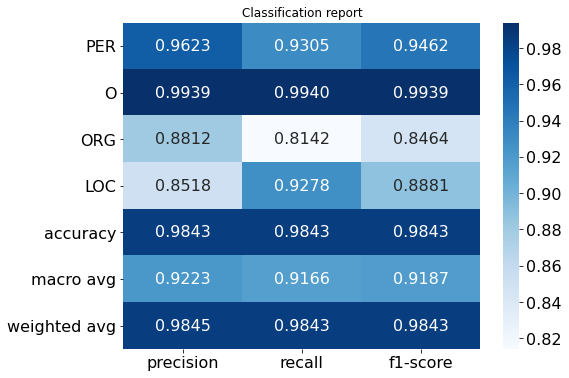

In [83]:
plot_classification_report(test_true, test_pred, label_vocabulary)

### Confusion matrix

In [0]:
def plot_confusion_matrix(y_true: List[int], y_pred: List[int], 
                          label_vocab: Vocabulary, 
                          font_size: Optional[int] = 16,
                          normalize: Optional[bool] = False, 
                          title: Optional[str] = None, 
                          cmap: Optional = plt.cm.Blues):
    """
    Plots the confusion matrix of the predictions of a model.

    Args:
        y_true:         Ground truth labels.
        y_pred:         Predicted labels.
        label_vocab:    Vocabulary with the labels for decoding.
        font_size:      Font size.
        title:          Title of the figure.
        cmap:           Colormap to use for visualization.
    """
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    labels = [i for i,l in label_vocab.itos.items() if l != "<pad>"]
    target_names = [l for i,l in label_vocab.itos.items() if l != "<pad>"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, None]

    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.5 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    fig.colorbar(im, cax=cax)

    # Set ticks and labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=target_names,
           yticklabels=target_names)
    
    ax.tick_params(labelsize=font_size)
    cax.tick_params(labelsize=font_size)           
    ax.set_ylabel("True label", fontdict={"fontsize": font_size})
    ax.set_xlabel("Predicted label", fontdict={"fontsize": font_size})
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data to create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    size=font_size)
    
    ax.set_title(title, fontdict={"fontsize": font_size})
    fig.tight_layout()
    plt.grid(False)
    plt.show()

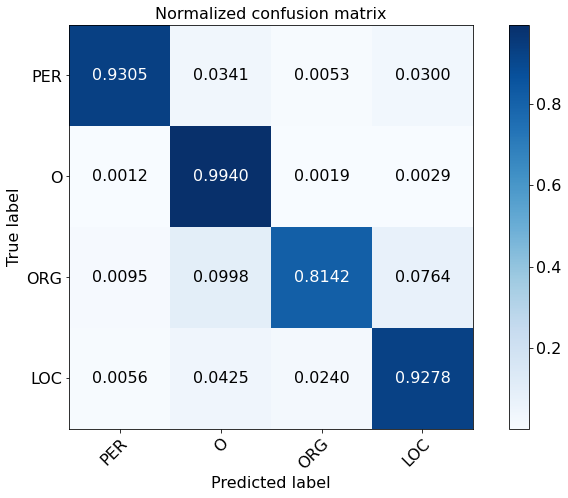

In [85]:
plot_confusion_matrix(test_true, test_pred, label_vocabulary, normalize=True)